In [36]:
import earthnet_minicuber as emc
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import datetime
import folium
import xarray as xr
import rioxarray as rioxr
cmap_veg = clr.LinearSegmentedColormap.from_list('veg', ['#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#006837','#004529'])

In [37]:
# Hide warnings (many since some xarray class uses some deprecated python function on 3.9)
import warnings
warnings.filterwarnings('ignore')

In [50]:
def convert_nc_to_tiff(nc_file, out_dir):
    # Load the NetCDF file using xarray
    filename = nc_file.split("/")[-1].replace(".nc", "")
    if out_dir[1] != '/':
        out_dir = out_dir + '/'

    ds = xr.open_dataset(nc_file).rename({"lat": "y", "lon": "x"})
    timestep = ds.time.min().values

    for i in range(ds.sizes["time"]):
        ndvi = ds.sel(time=timestep)
        ndvi = ndvi.rio.write_crs("EPSG:4326") 
        ndvi = ndvi.rio.to_raster(f"{out_dir}{filename}_{i+1}.tiff")
        timestep = timestep + np.timedelta64(5, 'D')


    print(f"Converted {nc_file} to tiff file")
    return

convert_nc_to_tiff("E:/DZ/predictions/contextformer6M_seed42/JAS21/minicube_0_29SND_39.29_-8.56.nc", "C:/Users/dozhang/Downloads/location1")

Converted E:/DZ/predictions/contextformer6M_seed42/JAS21/minicube_0_29SND_39.29_-8.56.nc to tiff file


In [51]:
def minicube_to_tiff(nc_file, out_dir):
    filename = nc_file.split("/")[-1].replace(".nc", "")
    if out_dir[1] != '/':
        out_dir = out_dir + '/'
    ds = xr.open_dataset(nc_file).rename({"lat": "y", "lon": "x"})
    ds["nasa_dem"].rio.write_crs("EPSG:4326").rio.to_raster(f"{out_dir}{filename}_nasa_dem.tiff")
    ds["esawc_lc"].rio.write_crs("EPSG:4326").rio.to_raster(f"{out_dir}{filename}_esawc.tiff") 
    
    return

minicube_to_tiff("C:/Users/dozhang/Documents/GitHub/greenearthnet/development/greenearthnet/replicated_minicubes/JAS2021_replicated_minicube_0_29SND_39.29_-8.56.nc", "C:/Users/dozhang/Downloads/location1")

In [26]:
tif = rioxr.open_rasterio("C:/Users/dozhang/Downloads/geom_90M_n45e020.tif")
tif

<xarray.DataArray (band: 1, y: 6000, x: 6000)> Size: 36MB
[36000000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 48kB 20.0 20.0 20.0 20.0 ... 25.0 25.0 25.0 25.0
  * y            (y) float64 48kB 50.0 50.0 50.0 50.0 ... 45.0 45.0 45.0 45.0
    spatial_ref  int32 4B 0
Attributes:
    TIFFTAG_IMAGEDESCRIPTION:  geom geomorphometry variable derived from MERI...
    TIFFTAG_DATETIME:          2019
    TIFFTAG_ARTIST:            Giuseppe Amatulli (giuseppe.amatulli@gmail.com)
    AREA_OR_POINT:             Area
    _FillValue:                0
    scale_factor:              1.0
    add_offset:                0.0

In [4]:
bands = ['TG', 'TN', 'TX', 'RR', 'PP', 'HU', 'FG', 'QQ']
paths = ["C:/Users/dozhang/Downloads/tg_ens_mean_0.1deg_reg_v26.0e.nc", 
         "C:/Users/dozhang/Downloads/tn_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/tx_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/rr_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/pp_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/hu_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/fg_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/qq_ens_mean_0.1deg_reg_v26.0e.nc"]
bands_dict = dict(zip(bands, paths))
specs = {
    "lon_lat": (22.05, 47.37), # center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-03-12/2021-08-04",
    "providers": [
        {
            "name": "s2",
            "kwargs": {
                "bands": ["B02", "B03", "B04", "B8A", "SCL"],  # , "B09", "B11", "B12"],
                "best_orbit_filter": False,
                "five_daily_filter": True,
                "brdf_correction": False,
                "cloud_mask": True,
                "cloud_mask_rescale_factor": 2,
                "aws_bucket": "planetary_computer",
            },
        },

            # RasterioIOError('CURL error: schannel: CertGetCertificateChain trust error CERT_TRUST_IS_UNTRUSTED_ROOT')
            # {"name": "srtm", "kwargs": {"bands": ["dem"]}},
            
            {"name": "nasa", "kwargs": {}},
            {"name": "alos", "kwargs": {}},
            {"name": "cop", "kwargs": {}},
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"},
        },
        {
            "name": "geom",
            "kwargs": {"filepath": "C:/Users/dozhang/Downloads/geom_90M_n45e020.tif"}
        },
        {
            "name": "eobs",
            "kwargs": {"bands": bands_dict}
        }
    ],
}

In [5]:
# cube = emc.load_minicube(specs, compute = True)
# path = "E:\DZ\greenearthnet\ood-t_chopped\JAS21\minicube_0_29SND_39.29_-8.56.nc"
path = "E:\DZ\greenearthnet\ood-t_chopped\MAM21\minicube_225_34TET_47.37_22.05.nc"
# path = "C:/Users/dozhang/Downloads/MJJ_reproduced_minicube_225_34TET_47.37_22.05.nc"
# path = "E:\DZ\predictions\contextformer6M_seed42\JAS21\minicube_0_29SND_39.29_-8.56.nc"
test = xr.open_dataset(path)
test

<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-01-07 ... 2021-06-05
  * lon                  (lon) float64 1kB 22.03 22.03 22.03 ... 22.07 22.07
  * lat                  (lat) float64 1kB 47.38 47.38 47.38 ... 47.35 47.35
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB ...
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry

In [62]:
input

<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-03-08 ... 2021-08-04
  * lon                  (lon) float64 1kB 22.03 22.03 22.03 ... 22.07 22.07
  * lat                  (lat) float64 1kB 47.38 47.38 47.38 ... 47.35 47.35
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB nan nan nan nan ... nan nan nan 1.0
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry

In [35]:
cube = cube.drop_vars(["angle"])

In [6]:
cube

<xarray.Dataset> Size: 115MB
Dimensions:   (time: 146, lon: 128, lat: 128)
Coordinates:
  * time      (time) datetime64[ns] 1kB 2021-03-12 2021-03-13 ... 2021-08-04
  * lon       (lon) float64 1kB 22.03 22.03 22.03 22.03 ... 22.07 22.07 22.07
  * lat       (lat) float64 1kB 47.38 47.38 47.38 47.38 ... 47.36 47.36 47.36
Data variables: (12/20)
    s2_SCL    (time, lat, lon) float64 19MB 5.0 5.0 5.0 7.0 ... 7.0 7.0 2.0 2.0
    s2_mask   (time, lat, lon) float64 19MB 0.0 0.0 0.0 0.0 ... 3.0 3.0 3.0 3.0
    s2_avail  (time) float32 584B 1.0 nan nan nan nan ... nan nan nan nan 1.0
    s2_B02    (time, lat, lon) float64 19MB 0.04023 0.03408 ... 0.05452 0.05095
    s2_B03    (time, lat, lon) float64 19MB 0.05117 0.044 ... 0.0601 0.05792
    s2_B04    (time, lat, lon) float64 19MB 0.07044 0.0599 ... 0.06783 0.06536
    ...        ...
    eobs_qq   (time) float32 584B 201.0 190.0 171.0 87.0 ... 223.0 262.0 303.0
    nasa_dem  (lat, lon) float64 131kB 134.0 133.4 132.4 ... 106.8 107.3 106.8
    alos_dem  (lat, lon) float64 131kB 133.7 132.4 131.7 ... 108.4 109.0 108.6
    cop_dem   (lat, lon) float64 131kB 132.5 132.0 131.7 ... 105.7 105.8 105.9
    esawc_lc  (lat, lon) float32 66kB 40.0 40.0 40.0 40.0 ... 40.0 40.0 40.0
    geom_cls  (lat, lon) float32 66kB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
Attributes:
    history:  Created on 2025-09-30 22:26:53.407912 with the earthnet-minicub...

In [20]:
# input = xr.open_dataset("E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_225_34TET_47.37_22.05.nc")
# emc.plot_rgb(input, mask=True)
# emc.plot_rgb(cube, mask=True)
# test = xr.open_dataset("E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_227_34TFL_40.83_22.37.nc")
# test = xr.open_dataset("E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_225_34TET_47.37_22.05.nc")
test = xr.open_dataset("E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_241_34VCL_59.04_17.96.nc")
test
# emc.plot_rgb(test, mask=False)
# input = xr.open_dataset("C:/Users/dozhang/Documents/GitHub/greenearthnet/development/greenearthnet/replicated_minicubes/MJJ_reproduced_minicube_225_34TET_47.37_22.05.nc")
# input

<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-03-10 ... 2021-08-06
  * lon                  (lon) float64 1kB 17.93 17.93 17.93 ... 17.98 17.98
  * lat                  (lat) float64 1kB 59.06 59.06 59.06 ... 59.03 59.03
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB ...
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry

### If instead of on-the-fly, you prefer to save the minicube to disk:

In [52]:
bands = ['TG', 'TN', 'TX', 'RR', 'PP', 'HU', 'FG', 'QQ']
paths = ["C:/Users/dozhang/Downloads/tg_ens_mean_0.1deg_reg_v26.0e.nc", 
         "C:/Users/dozhang/Downloads/tn_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/tx_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/rr_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/pp_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/hu_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/fg_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/qq_ens_mean_0.1deg_reg_v26.0e.nc"]
bands_dict = dict(zip(bands, paths))
specs = {
    "lon_lat": (-8.56, 39.29), # center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-05-10/2021-10-06",
    "providers": [
        {
            "name": "s2",
            "kwargs": {
                "bands": ["B02", "B03", "B04", "B8A", "SCL"],  # , "B09", "B11", "B12"],
                "best_orbit_filter": True,
                "five_daily_filter": False,
                "brdf_correction": True,
                "cloud_mask": True,
                "cloud_mask_rescale_factor": 2,
                "aws_bucket": "planetary_computer",
            },
        },

            # RasterioIOError('CURL error: schannel: CertGetCertificateChain trust error CERT_TRUST_IS_UNTRUSTED_ROOT')
            # {"name": "srtm", "kwargs": {"bands": ["dem"]}},
            
            {"name": "nasa", "kwargs": {}},
            {"name": "alos", "kwargs": {}},
            {"name": "cop", "kwargs": {}},
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"},
        },
        {
            "name": "geom",
            "kwargs": {"filepath": "C:/Users/dozhang/Downloads/geom_90M_n35w010.tif"}
        },
        {
            "name": "eobs",
            "kwargs": {"bands": bands_dict}
        }
    ],
}
# cube = emc.Minicuber.save_minicube(specs,"C:/Users/dozhang/Downloads/JAS_replicated_minicube_0_29SND_39.29_-8.56.nc")
portugal = emc.load_minicube(specs, compute = True)

Loading Sentinel2 for 2021-05-10/2021-05-31
Loading EOBS for 2021-05-10/2021-05-31
Loading Sentinel2 for 2021-06-01/2021-06-30
Loading EOBS for 2021-06-01/2021-06-30
Loading Sentinel2 for 2021-07-01/2021-07-31
Loading EOBS for 2021-07-01/2021-07-31
Loading Sentinel2 for 2021-08-01/2021-08-31
Loading EOBS for 2021-08-01/2021-08-31
Loading Sentinel2 for 2021-09-01/2021-10-06
Loading EOBS for 2021-09-01/2021-10-06
Loading NASADEM
Loading ALOSWorld
Loading Copernicus30
Loading ESAWorldcover
Loading Geomorphons


In [ ]:
bands = ['TG', 'TN', 'TX', 'RR', 'PP', 'HU', 'FG', 'QQ']
paths = ["C:/Users/dozhang/Downloads/tg_ens_mean_0.1deg_reg_v26.0e.nc", 
         "C:/Users/dozhang/Downloads/tn_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/tx_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/rr_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/pp_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/hu_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/fg_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/qq_ens_mean_0.1deg_reg_v26.0e.nc"]
bands_dict = dict(zip(bands, paths))
specs = {
    "lon_lat": (22.05, 47.37), # center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-03-07/2021-08-04",
    "providers": [
        {
            "name": "s2",
            "kwargs": {
                "bands": ["B02", "B03", "B04", "B8A", "SCL"],  # , "B09", "B11", "B12"],
                "best_orbit_filter": False,
                "five_daily_filter": True,
                "brdf_correction": False,
                "cloud_mask": True,
                "cloud_mask_rescale_factor": 2,
                "aws_bucket": "planetary_computer",
            },
        },

            # RasterioIOError('CURL error: schannel: CertGetCertificateChain trust error CERT_TRUST_IS_UNTRUSTED_ROOT')
            # {"name": "srtm", "kwargs": {"bands": ["dem"]}},
            
            {"name": "nasa", "kwargs": {}},
            {"name": "alos", "kwargs": {}},
            {"name": "cop", "kwargs": {}},
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"},
        },
        {
            "name": "geom",
            "kwargs": {"filepath": "C:/Users/dozhang/Downloads/geom_90M_n45e020.tif"}
        },
        {
            "name": "eobs",
            "kwargs": {"bands": bands_dict}
        }
    ],
}
# cube = emc.Minicuber.save_minicube(specs,"C:/Users/dozhang/Downloads/MJJ_replicated_minicube_225_34TET_47.37_22.05.nc")
romania = emc.load_minicube(specs, compute = True)
romania = romania.drop_sel(time="2021-03-07T00:00:00")
# hungary

Loading Sentinel2 for 2021-03-07/2021-03-31
Loading EOBS for 2021-03-07/2021-03-31
Loading Sentinel2 for 2021-04-01/2021-04-30
Loading EOBS for 2021-04-01/2021-04-30
Loading Sentinel2 for 2021-05-01/2021-05-31
Loading EOBS for 2021-05-01/2021-05-31
Loading Sentinel2 for 2021-06-01/2021-06-30
Loading EOBS for 2021-06-01/2021-06-30
Loading Sentinel2 for 2021-07-01/2021-08-04
Loading EOBS for 2021-07-01/2021-08-04
Loading NASADEM
Loading ALOSWorld
Loading Copernicus30
Loading ESAWorldcover
Loading Geomorphons


In [65]:
bands = ['TG', 'TN', 'TX', 'RR', 'PP', 'HU', 'FG', 'QQ']
paths = ["C:/Users/dozhang/Downloads/tg_ens_mean_0.1deg_reg_v26.0e.nc", 
         "C:/Users/dozhang/Downloads/tn_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/tx_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/rr_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/pp_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/hu_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/fg_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/qq_ens_mean_0.1deg_reg_v26.0e.nc"]
bands_dict = dict(zip(bands, paths))
specs = {
    "lon_lat": (17.96, 59.04), # center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this on a local UTM grid..
    "time_interval": "2021-03-09/2021-08-06",
    "providers": [
        {
            "name": "s2",
            "kwargs": {
                "bands": ["B02", "B03", "B04", "B8A", "SCL"],  # , "B09", "B11", "B12"],
                "best_orbit_filter": False,
                "five_daily_filter": True,
                "brdf_correction": False,
                "cloud_mask": True,
                "cloud_mask_rescale_factor": 2,
                "aws_bucket": "planetary_computer",
            },
        },

            # RasterioIOError('CURL error: schannel: CertGetCertificateChain trust error CERT_TRUST_IS_UNTRUSTED_ROOT')
            # {"name": "srtm", "kwargs": {"bands": ["dem"]}},
            
            {"name": "nasa", "kwargs": {}},
            {"name": "alos", "kwargs": {}},
            {"name": "cop", "kwargs": {}},
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"},
        },
        {
            "name": "geom",
            "kwargs": {"filepath": "C:/Users/dozhang/Downloads/geom_90M_n55e015.tif"}
        },
        {
            "name": "eobs",
            "kwargs": {"bands": bands_dict}
        }
    ],
}

# cube = emc.Minicuber.save_minicube(specs,"C:/Users/dozhang/Downloads/MJJ2021_replicated_minicube_241_34VCL_59.04_17.96.nc")
sweden = emc.load_minicube(specs, compute = True)
sweden = sweden.drop_sel(time="2021-03-09T00:00:00")
# cube
# emc.plot_rgb(sweden, mask=False)

Loading Sentinel2 for 2021-03-09/2021-03-31
Loading EOBS for 2021-03-09/2021-03-31
Loading Sentinel2 for 2021-04-01/2021-04-30
Loading EOBS for 2021-04-01/2021-04-30
Loading Sentinel2 for 2021-05-01/2021-05-31
Loading EOBS for 2021-05-01/2021-05-31
Loading Sentinel2 for 2021-06-01/2021-06-30
Loading EOBS for 2021-06-01/2021-06-30
Loading Sentinel2 for 2021-07-01/2021-08-06
Loading EOBS for 2021-07-01/2021-08-06
Loading NASADEM
Loading ALOSWorld
Loading Copernicus30
Loading ESAWorldcover
Loading Geomorphons


In [98]:
bands = ['TG', 'TN', 'TX', 'RR', 'PP', 'HU', 'FG', 'QQ']
paths = ["C:/Users/dozhang/Downloads/tg_ens_mean_0.1deg_reg_v26.0e.nc", 
         "C:/Users/dozhang/Downloads/tn_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/tx_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/rr_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/pp_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/hu_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/fg_ens_mean_0.1deg_reg_v26.0e.nc",
         "C:/Users/dozhang/Downloads/qq_ens_mean_0.1deg_reg_v26.0e.nc"]
bands_dict = dict(zip(bands, paths))
specs = {
    "lon_lat": (-72.17, 42.54), # center pixel
    # "lon_lat": (-76.56, 36.62), # center pixel
    "xy_shape": (128, 128), # width, height of cutout around center pixel
    "resolution": 20, # in meters.. will use this on a local UTM grid..
    "time_interval": "2023-05-02/2023-09-29",
    "providers": [
        {
            "name": "s2",
            "kwargs": {
                "bands": ["B02", "B03", "B04", "B8A", "SCL"],  # , "B09", "B11", "B12"],
                "best_orbit_filter": False,
                "five_daily_filter": True,
                "brdf_correction": False,
                "cloud_mask": True,
                "cloud_mask_rescale_factor": 2,
                "aws_bucket": "planetary_computer",
            },
        },

        #     # RasterioIOError('CURL error: schannel: CertGetCertificateChain trust error CERT_TRUST_IS_UNTRUSTED_ROOT')
        #     # {"name": "srtm", "kwargs": {"bands": ["dem"]}},
            
            {"name": "nasa", "kwargs": {}},
            {"name": "alos", "kwargs": {}},
            {"name": "cop", "kwargs": {}},
        {
            "name": "esawc",
            "kwargs": {"bands": ["lc"], "aws_bucket": "planetary_computer"},
        },
        {
            "name": "geom",
            "kwargs": {"filepath": "C:/Users/dozhang/Downloads/geom_90M_n40w075.tif"}
        },
        # {
        #     "name": "eobs",
        #     "kwargs": {"bands": bands_dict}
        # }
    ],
}
# cube = emc.Minicuber.save_minicube(specs,"C:/Users/dozhang/Downloads/MJJ_replicated_minicube_225_34TET_47.37_22.05.nc")
harvard = emc.load_minicube(specs, compute = True)
harvard = harvard.drop_sel(time="2023-05-02T00:00:00")
harvard


Loading Sentinel2 for 2023-05-02/2023-05-31
Loading Sentinel2 for 2023-06-01/2023-06-30
Loading Sentinel2 for 2023-07-01/2023-07-31
Loading Sentinel2 for 2023-08-01/2023-08-31
Loading Sentinel2 for 2023-09-01/2023-09-29
Loading NASADEM
Loading ALOSWorld
Loading Copernicus30
Loading ESAWorldcover
Loading Geomorphons


<xarray.Dataset> Size: 22MB
Dimensions:   (time: 27, lon: 128, lat: 128)
Coordinates:
  * time      (time) datetime64[ns] 216B 2023-05-07 2023-05-12 ... 2023-09-29
  * lon       (lon) float64 1kB -72.19 -72.19 -72.19 ... -72.15 -72.15 -72.15
  * lat       (lat) float64 1kB 42.55 42.55 42.55 42.55 ... 42.53 42.53 42.53
Data variables:
    s2_SCL    (time, lat, lon) float64 4MB 4.0 4.0 4.0 4.0 ... 8.0 8.0 8.0 8.0
    s2_mask   (time, lat, lon) float64 4MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    s2_avail  (time) float32 108B 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    s2_B02    (time, lat, lon) float64 4MB 0.0519 0.05302 ... 1.078 1.087
    s2_B03    (time, lat, lon) float64 4MB 0.07345 0.07629 ... 1.006 1.005
    s2_B04    (time, lat, lon) float64 4MB 0.08535 0.08765 ... 0.9457 0.9496
    s2_B8A    (time, lat, lon) float64 4MB 0.2543 0.2714 ... 0.8765 0.8809
    nasa_dem  (lat, lon) float64 131kB 341.5 343.2 345.5 ... 298.9 297.7 296.8
    alos_dem  (lat, lon) float64 131kB 343.3 345.2 347.8 ... 298.7 297.3 296.2
    cop_dem   (lat, lon) float64 131kB 352.6 354.5 356.5 ... 302.5 301.6 301.9
    esawc_lc  (lat, lon) float32 66kB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0
    geom_cls  (lat, lon) float32 66kB 6.0 6.0 6.0 6.0 6.0 ... 7.0 7.0 7.0 7.0
Attributes:
    history:  Created on 2025-10-08 06:44:56.916630 with the earthnet-minicub...

In [35]:
output = xr.open_dataset("E:\DZ\predictions\contextformer6M_seed42\JAS21\minicube_0_29SND_39.29_-8.56.nc")
output

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 20, lat: 128, lon: 128)
Coordinates:
  * time       (time) datetime64[ns] 160B 2021-07-03 2021-07-08 ... 2021-10-06
  * lat        (lat) float64 1kB 39.3 39.3 39.3 39.3 ... 39.28 39.28 39.28 39.28
  * lon        (lon) float64 1kB -8.571 -8.571 -8.571 ... -8.542 -8.542 -8.542
Data variables:
    ndvi_pred  (time, lat, lon) float32 1MB ...

In [38]:
st1 = xr.open_dataset("E:\DZ\greenearthnet\ood-st_chopped\MJJ21\minicube_810_56.75_16.05.nc")
# emc.plot_rgb(st1, mask=False)
st1

<xarray.Dataset> Size: 119MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2021-03-10 ... 2021-08-06
  * lon                  (lon) float64 1kB 15.64 15.64 15.64 ... 15.68 15.68
  * lat                  (lat) float64 1kB 56.27 56.27 56.27 ... 56.25 56.25
    sentinel:product_id  float64 8B ...
    latitude_eobs        float64 8B ...
    longitude_eobs       float64 8B ...
Data variables: (12/21)
    s2_SCL               (time, lat, lon) float64 20MB ...
    s2_avail             (time) float64 1kB ...
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    ...                   ...
    eobs_rr              (time) float64 1kB ...
    eobs_tg              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
    eobs_fgv26           (time) float64 1kB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    provided_by:         Max-Planck-Institute for Biogeochemistry

<xarray.Dataset> Size: 138MB
Dimensions:              (time: 150, lon: 128, lat: 128)
Coordinates:
  * time                 (time) datetime64[ns] 1kB 2017-06-20 ... 2017-11-16
  * lon                  (lon) float64 1kB -7.826 -7.825 ... -7.796 -7.796
  * lat                  (lat) float64 1kB 39.53 39.53 39.53 ... 39.5 39.5 39.5
    sentinel:product_id  float64 8B ...
    longitude_eobs       float64 8B ...
    latitude_eobs        float64 8B ...
Data variables: (12/21)
    s2_avail             (time) float64 1kB nan nan nan nan ... nan nan nan 1.0
    s2_B02               (time, lat, lon) float64 20MB ...
    s2_B03               (time, lat, lon) float64 20MB ...
    s2_B04               (time, lat, lon) float64 20MB ...
    s2_B8A               (time, lat, lon) float64 20MB ...
    alos_dem             (lat, lon) float64 131kB ...
    ...                   ...
    eobs_qq              (time) float64 1kB ...
    eobs_rr              (time) float64 1kB ...
    eobs_tn              (time) float64 1kB ...
    eobs_tx              (time) float64 1kB ...
    nasa_dem             (lat, lon) float64 131kB ...
    s2_dlmask            (time, lat, lon) float64 20MB ...
Attributes:
    dataset_name:        EarthNet2021x
    dataset_name_short:  en21x
    dataset_version:     v1.0
    description:         This is a minicube from the EarthNet2021x dataset, a...
    license:             \nLicense\nEarthNet2021x is shared under CC-BY-NC-SA...
    provided_by:         Max-Planck-Institute for Biogeochemistry

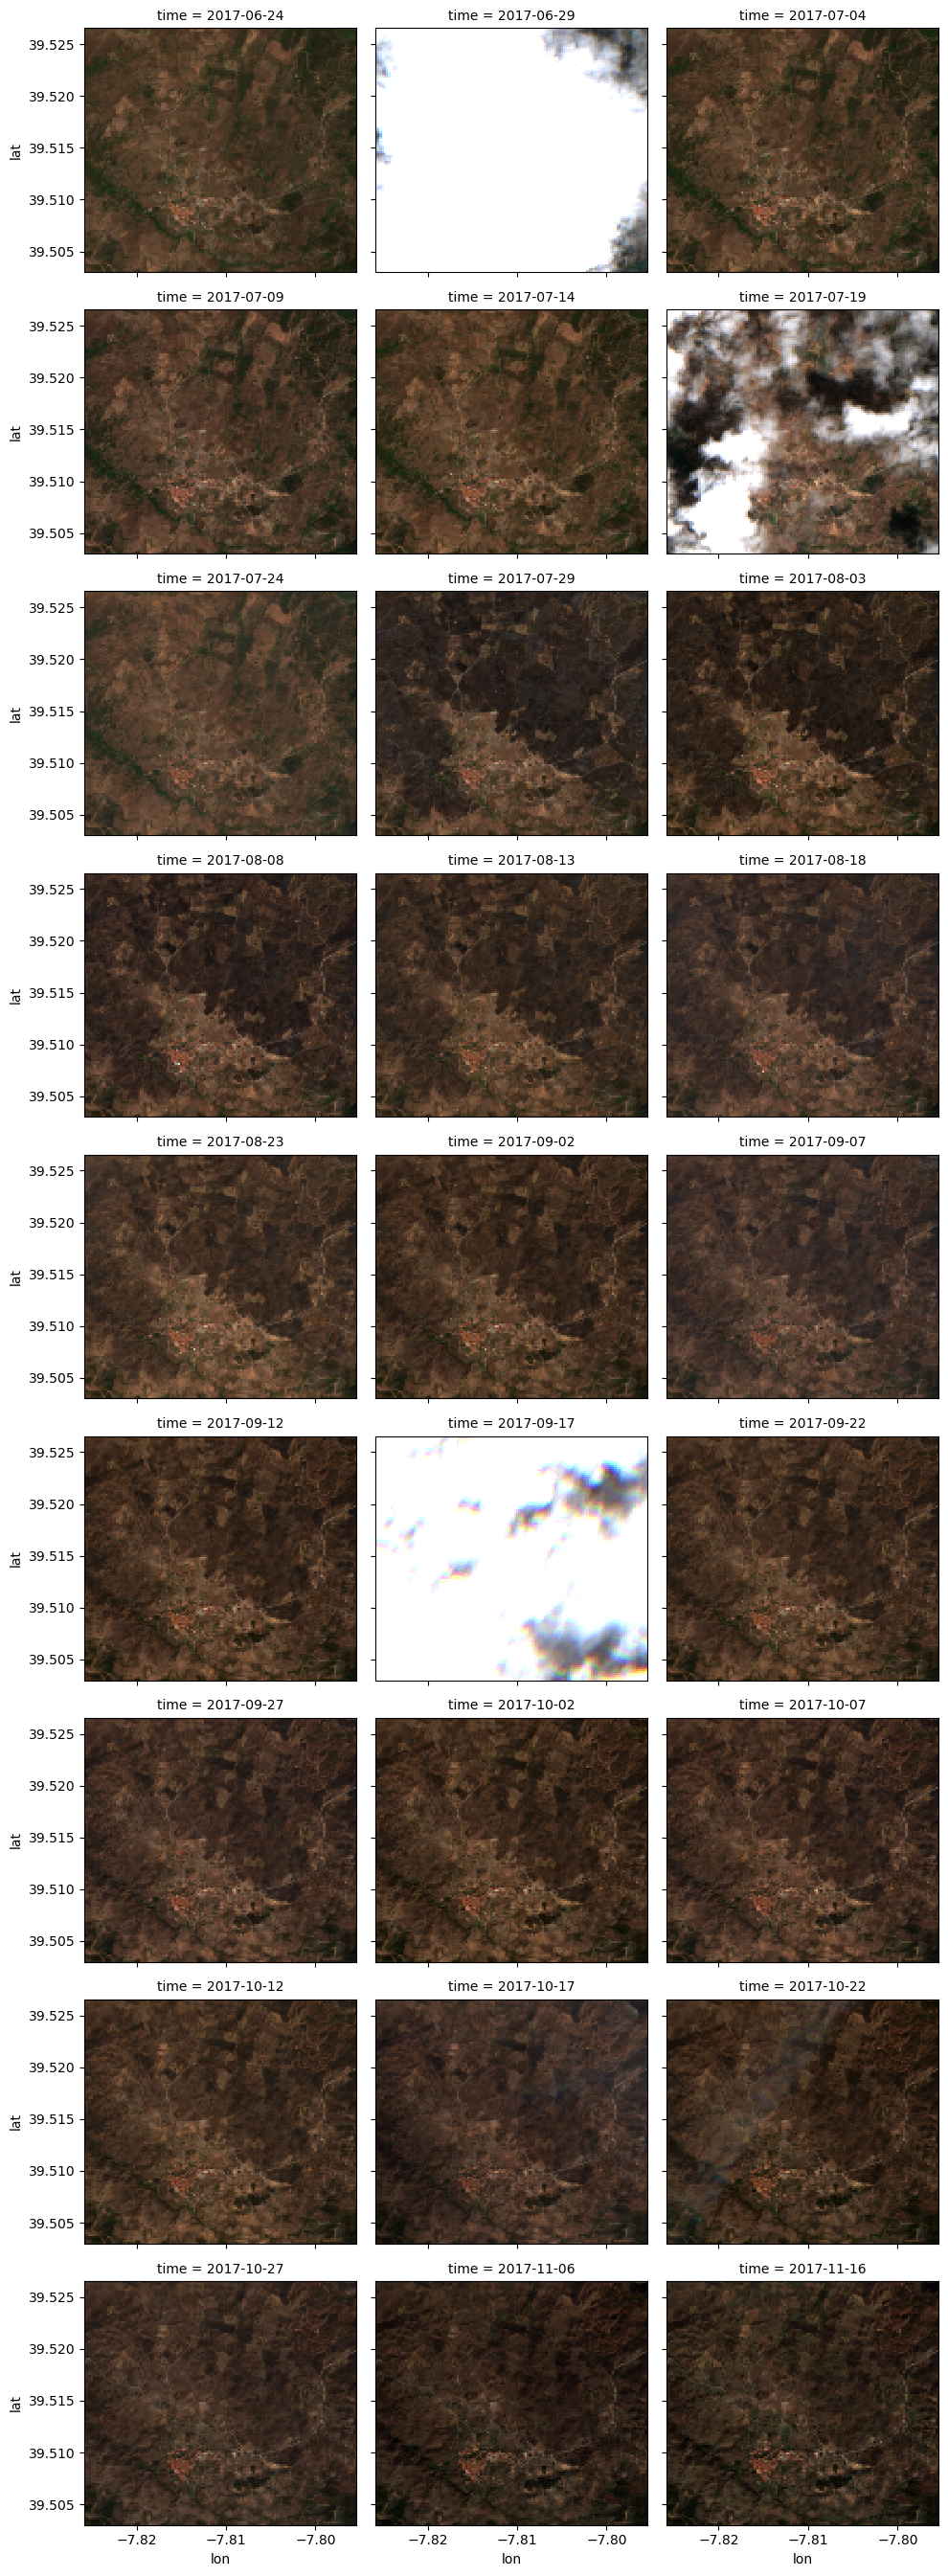

In [42]:
st2 = xr.open_dataset(r"E:\DZ\greenearthnet\train\29SND\29SND_2017-06-20_2017-11-16_1209_1337_5049_5177_18_98_78_158.nc")
# r"E:\DZ\greenearthnet\train\29SND\29SND_2017-06-20_2017-11-16_1209_1337_5049_5177_18_98_78_158.nc"
emc.plot_rgb(st2, mask=False)
st2

# Folium plot

In [33]:
def map(minicube):
    x_min, x_max, y_min, y_max = minicube.lon[0].values, minicube.lon[-1].values, minicube.lat[-1].values, minicube.lat[0].values
    # Create map
    interactive_map = folium.Map(
        location=((y_min+y_max)/2, (x_min+x_max)/2),
        zoom_start=min(int((np.log(1000 / (x_max-x_min)) / np.log(2))), int((np.log(1000 / (y_max-y_min)) / np.log(2)))),
        tiles="http://mt1.google.com/vt/lyrs=y&z={z}&x={x}&y={y}",
        attr="Google",
        prefer_canvas=True,
    )
    
    folium.TileLayer('openstreetmap', show=False).add_to(interactive_map)
    
    # Create bounding box coordinates to overlay on map
    line_segments = [
        (y_min, x_min),
        (y_min, x_max),
        (y_max, x_max),
        (y_max, x_min),
        (y_min, x_min),
    ]

    # Add bounding box as an overlay
    interactive_map.add_child(
        folium.features.PolyLine(locations=line_segments, color="red", opacity=0.8)
    )
    #folium.PolyLine(locations=line_segments, color="red", opacity=0.8).add_to(interactive_map)
    
    return interactive_map

In [34]:
# PARAMS
S2_t = 1

In [35]:
rgb = cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time=S2_t).to_numpy()
rgb = np.nan_to_num(rgb, nan=0.0)
rgb = np.swapaxes(rgb, 0, 2)
rgb = np.swapaxes(rgb, 0, 1)

In [36]:
nasadem = cube.nasa_dem.to_numpy()
nasadem = (nasadem-np.nanmin(nasadem))/np.nanmax(nasadem) #minmax scale
nasadem = np.nan_to_num(nasadem, nan=np.nanmean(nasadem))

alos = cube.alos_dem.to_numpy()
alos = (alos-np.nanmin(alos))/np.nanmax(alos) #minmax scale
alos = np.nan_to_num(alos, nan=np.nanmean(alos))

cop = cube.cop_dem.to_numpy()
cop = (cop-np.nanmin(cop))/np.nanmax(cop) #minmax scale
cop = np.nan_to_num(cop, nan=np.nanmean(cop))


mask = cube["s2_mask"].isel(time=S2_t).where(lambda x: x>0).to_numpy()
mask = np.nan_to_num(mask, nan=0.0)


lc = cube.esawc_lc.to_numpy()
lc = np.nan_to_num(lc, nan=0.0)

tg = cube.eobs_tg.to_numpy()
tg = np.nan_to_num(tg, nan=0.0)

tn = cube.eobs_tn.to_numpy()
tn = np.nan_to_num(tn, nan=0.0)

tx = cube.eobs_tx.to_numpy()
tx = np.nan_to_num(tx, nan=0.0)

rr = cube.eobs_rr.to_numpy()
rr = np.nan_to_num(rr, nan=0.0)

pp = cube.eobs_pp.to_numpy()
pp = np.nan_to_num(pp, nan=0.0)

hu = cube.eobs_hu.to_numpy()
hu = np.nan_to_num(hu, nan=0.0)

fg = cube.eobs_fg.to_numpy()
fg = np.nan_to_num(fg, nan=0.0)

qq = cube.eobs_qq.to_numpy()
qq = np.nan_to_num(qq, nan=0.0)

# ndvi_clims=[]
# for i in range(12):
#     clim = cube.ndviclim_mean.isel(time_clim=i).to_numpy()
#     clim = np.nan_to_num(clim, nan=0.0)
#     month = datetime.datetime.strptime(str(i+1), "%m").strftime("%b")
#     ndvi_clims.append({"month": month, "ndvi_mean": clim})


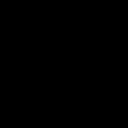
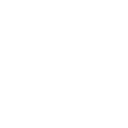
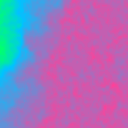
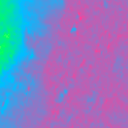
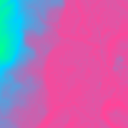
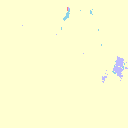

In [37]:
interactive_map = map(cube)

bounds = [[float(cube.lat[-1].values), float(cube.lon[0].values)], [float(cube.lat[0].values), float(cube.lon[-1].values)]]

# Add RGB layer
folium.raster_layers.ImageOverlay(
    image=rgb,
    bounds=bounds,
    mercator_project=True,
    name="Sentinel 2 RGB",
    opacity=0.95,
).add_to(interactive_map)

# Add cloud layer
folium.raster_layers.ImageOverlay(
    image=mask,
    bounds=bounds,
    mercator_project=True,
    name="S2 Mask",
    colormap = lambda x: (1, x/10, -x/2, x),
).add_to(interactive_map)


# Add NASADEM
folium.raster_layers.ImageOverlay(
    image=nasadem,
    bounds=bounds,
    mercator_project=True,
    name="NASADEM",
    opacity=0.75,
    show=False,
    colormap = plt.get_cmap("terrain"),
).add_to(interactive_map)

# Add ALOS
folium.raster_layers.ImageOverlay(
    image=alos,
    bounds=bounds,
    mercator_project=True,
    name="ALOS",
    opacity=0.75,
    show=False,
    colormap = plt.get_cmap("terrain"),
).add_to(interactive_map)


# Add COP
folium.raster_layers.ImageOverlay(
    image=cop,
    bounds=bounds,
    mercator_project=True,
    name="COP",
    opacity=0.75,
    show=False,
    colormap = plt.get_cmap("terrain"),
).add_to(interactive_map)

# Add ESA-WC
folium.raster_layers.ImageOverlay(
    image=lc/255,
    bounds=bounds,
    mercator_project=True,
    name="ESA WorldCover",
    opacity=0.8,
    show=False,
    colormap = plt.get_cmap("Set3"),
).add_to(interactive_map)

# # Add NDVI Climatology
# for clim in ndvi_clims:
#     folium.raster_layers.ImageOverlay(
#         image=clim['ndvi_mean'],
#         bounds=bounds,
#         mercator_project=True,
#         name=f"NDVI {clim['month']}",
#         opacity=0.9,
#         show=False,
#         colormap = cmap_veg,
#     ).add_to(interactive_map)
    
folium.map.LayerControl(position='topright', collapsed=False, autoZIndex=True).add_to(interactive_map)

interactive_map

# Other Plots

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07337819654909761..1.188879171500157].


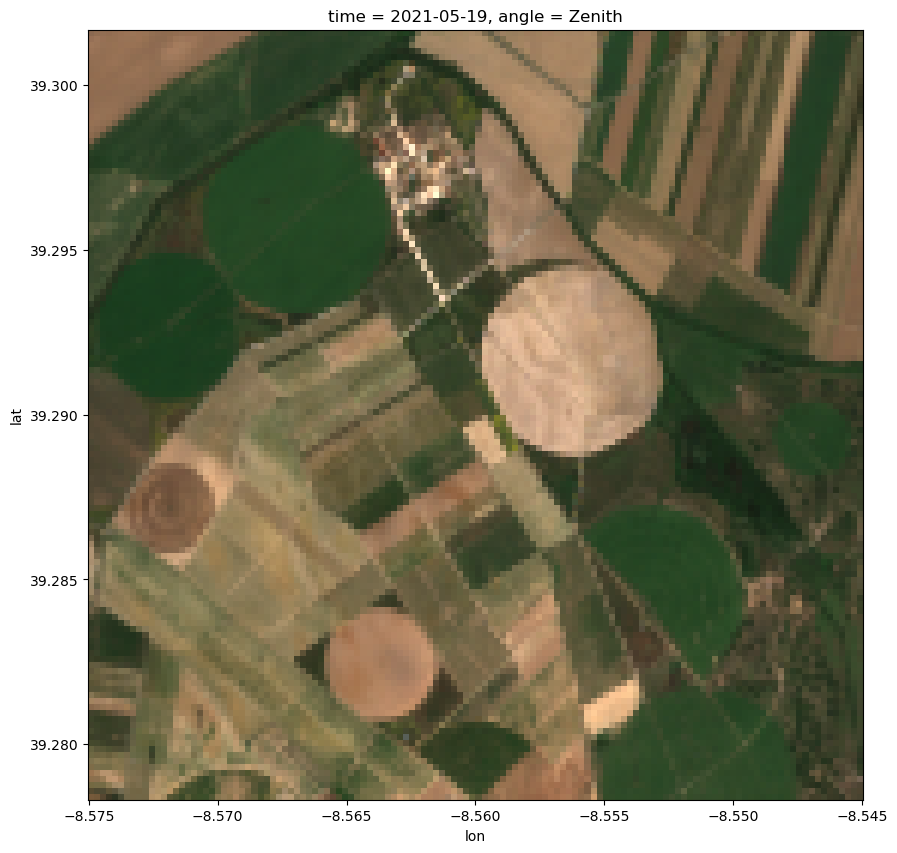

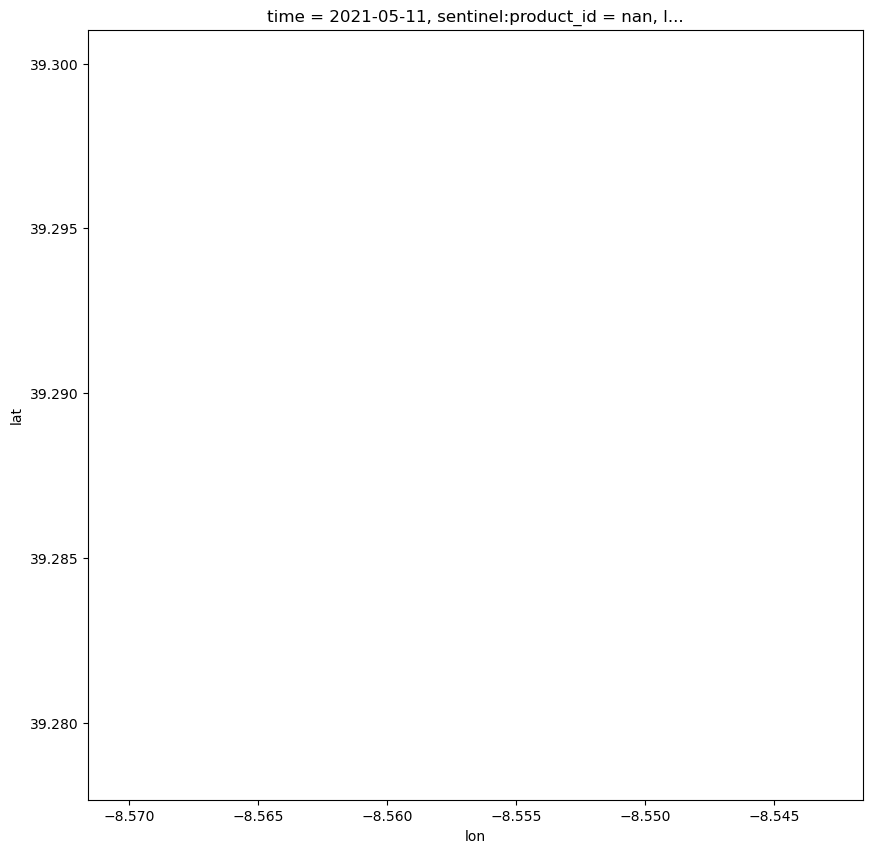

In [19]:
rgb_brightness_scaling=3

(cube[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t) * rgb_brightness_scaling).plot.imshow(rgb="band", figsize = (10, 10))
(input[["s2_B04", "s2_B03", "s2_B02"]].to_array("band").isel(time = S2_t) * rgb_brightness_scaling).plot.imshow(rgb="band", figsize = (10, 10))

In [85]:
# sweden
# emc.plot_rgb(sweden, mask=True)
# emc.plot_rgb(sweden, mask=False)
swedeninput = xr.open_dataset("E:\DZ\greenearthnet\ood-t_chopped\MJJ21\minicube_241_34VCL_59.04_17.96.nc")
# emc.plot_rgb(swedeninput.rename({"s2_dlmask": "s2_mask"}), mask=True)

In [82]:
sweden

<xarray.Dataset> Size: 118MB
Dimensions:   (time: 150, lon: 128, lat: 128)
Coordinates:
  * time      (time) datetime64[ns] 1kB 2021-03-10 2021-03-11 ... 2021-08-06
  * lon       (lon) float64 1kB 17.94 17.94 17.94 17.94 ... 17.98 17.98 17.98
  * lat       (lat) float64 1kB 59.05 59.05 59.05 59.05 ... 59.03 59.03 59.03
Data variables: (12/20)
    s2_SCL    (time, lat, lon) float64 20MB nan nan nan nan ... 4.0 4.0 4.0 4.0
    s2_mask   (time, lat, lon) float64 20MB nan nan nan nan ... 0.0 0.0 0.0 0.0
    s2_avail  (time) float32 600B nan nan nan nan 1.0 ... nan nan nan nan 1.0
    s2_B02    (time, lat, lon) float64 20MB nan nan nan ... 0.03479 0.04214
    s2_B03    (time, lat, lon) float64 20MB nan nan nan ... 0.04766 0.05559
    s2_B04    (time, lat, lon) float64 20MB nan nan nan ... 0.03548 0.04569
    ...        ...
    eobs_qq   (time) float32 600B 95.0 37.0 66.0 50.0 ... 247.0 264.0 250.0
    nasa_dem  (lat, lon) float64 131kB 49.39 50.44 51.4 ... 44.56 43.62 42.57
    alos_dem  (lat, lon) float64 131kB 49.29 51.33 54.69 ... 44.55 43.72 42.15
    cop_dem   (lat, lon) float64 131kB 50.67 52.94 54.55 ... 43.53 42.25 41.5
    esawc_lc  (lat, lon) float32 66kB 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0
    geom_cls  (lat, lon) float32 66kB 7.0 7.0 7.0 7.0 7.0 ... 3.0 5.0 5.0 5.0
Attributes:
    history:  Created on 2025-10-07 19:28:13.541145 with the earthnet-minicub...

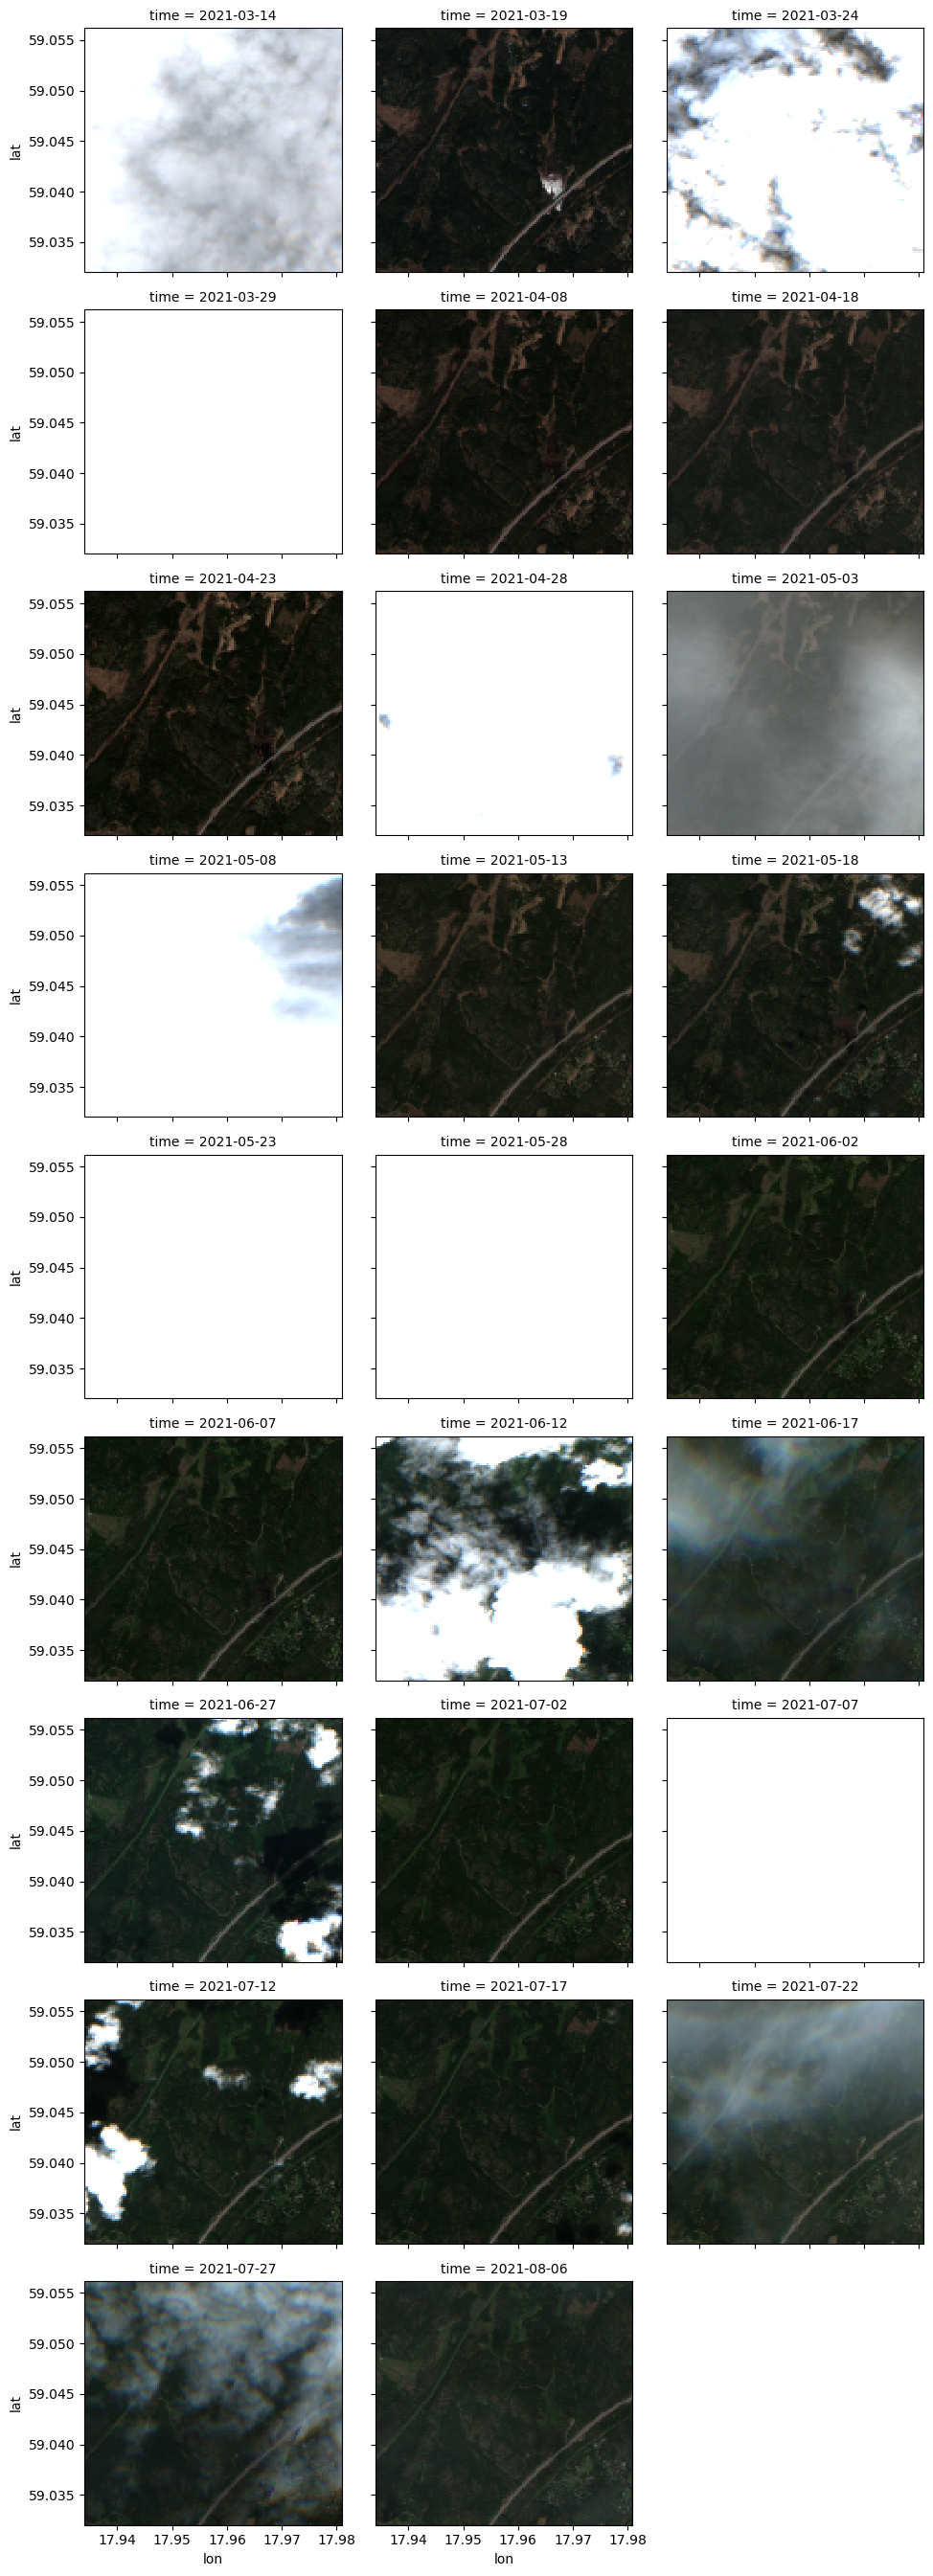

In [103]:
swedeninput
emc.plot_rgb(swedeninput.rename({"s2_dlmask": "s2_mask"}), mask=False)

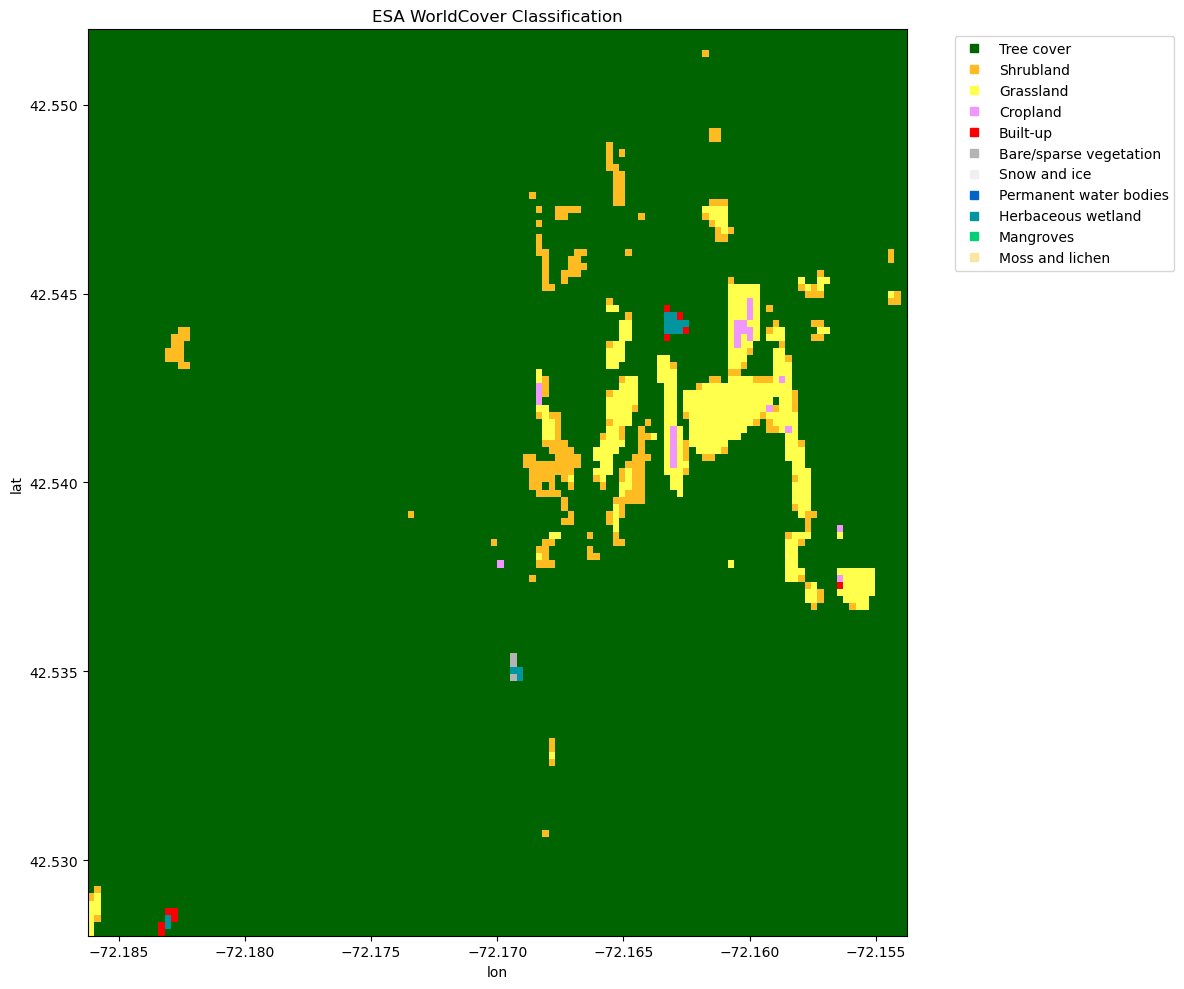

In [99]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# ESA WorldCover legend (class value → label)
classes = {
    10: "Tree cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Built-up",
    60: "Bare/sparse vegetation",
    70: "Snow and ice",
    80: "Permanent water bodies",
    90: "Herbaceous wetland",
    95: "Mangroves",
    100: "Moss and lichen",
}

# Official ESA color codes
colors = [
    "#006400",  # Tree cover
    "#ffbb22",  # Shrubland
    "#ffff4c",  # Grassland
    "#f096ff",  # Cropland
    "#fa0000",  # Built-up
    "#b4b4b4",  # Bare/sparse vegetation
    "#f0f0f0",  # Snow and ice
    "#0064c8",  # Water bodies
    "#0096a0",  # Wetlands
    "#00cf75",  # Mangroves
    "#fae6a0",  # Moss and lichen
]

# Create discrete colormap and normalization
cmap = mcolors.ListedColormap(colors)
bounds = np.array(list(classes.keys()) + [110])  # upper bound beyond last class
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Function to plot any xarray DataArray containing WorldCover data
def plot_worldcover(data, title="ESA WorldCover Classification"):
    plt.figure(figsize=(12, 10))
    im = data.esawc_lc.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)
    
    # Custom legend
    patches = [
        plt.plot([], [], marker="s", ls="", color=colors[i], label=list(classes.values())[i])[0]
        for i in range(len(classes))
    ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you loaded the data as an xarray DataArray (e.g., from rioxarray)
# wc = xr.open_rasterio("ESA_WorldCover_2021_v200_N39W009_Map.tif").squeeze()
# plot_worldcover(wc)
plot_worldcover(harvard)


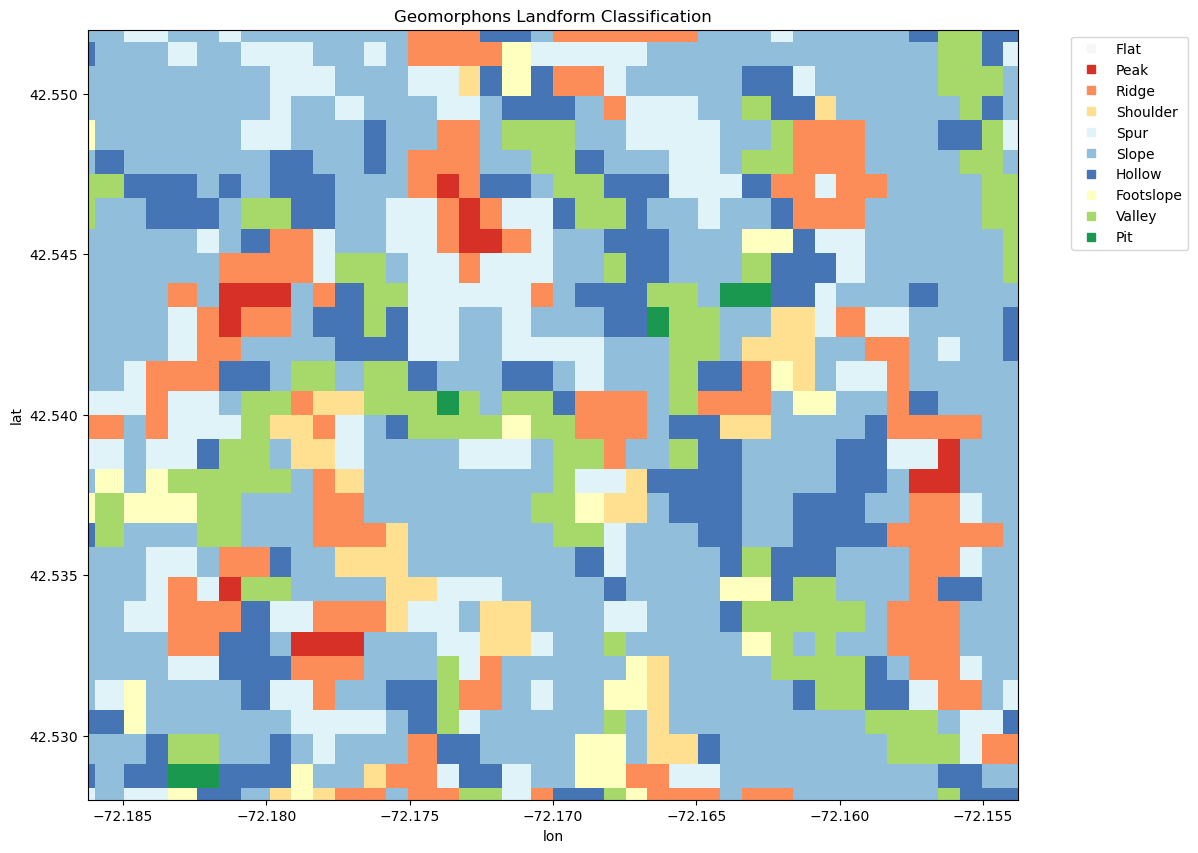

In [101]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Geomorphon landform classes (1–10/11 depending on dataset)
classes = {
    1: "Flat",
    2: "Peak",
    3: "Ridge",
    4: "Shoulder",
    5: "Spur",
    6: "Slope",
    7: "Hollow",
    8: "Footslope",
    9: "Valley",
    10: "Pit",
}

# Assign a color to each class
colors = [
    "#f7f7f7",  # Flat
    "#d73027",  # Peak
    "#fc8d59",  # Ridge
    "#fee090",  # Shoulder
    "#e0f3f8",  # Spur
    "#91bfdb",  # Slope
    "#4575b4",  # Hollow
    "#ffffbf",  # Footslope
    "#a6d96a",  # Valley
    "#1a9850",  # Pit
]

# Discrete colormap
cmap = mcolors.ListedColormap(colors)
bounds = list(classes.keys())
norm = mcolors.BoundaryNorm(bounds + [bounds[-1] + 1], cmap.N)

# Plot
def plot_geomorphons(data, title="Geomorphons Landform Classification"):
    plt.figure(figsize=(12, 10))
    im = data.geom_cls.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

    # Custom legend
    patches = [plt.plot([], [], marker="s", ls="", color=colors[i-1],
                        label=classes[i])[0] for i in classes]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.show()

plot_geomorphons(harvard)

# # Plot
# plt.figure(figsize=(12, 10))
# im = input.geom_cls.plot.imshow(cmap=cmap, norm=norm, add_colorbar=False)

# # Custom legend
# patches = [plt.plot([], [], marker="s", ls="", color=colors[i-1],
#                     label=classes[i])[0] for i in classes]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title("Geomorphons Landform Classification")
# plt.show()



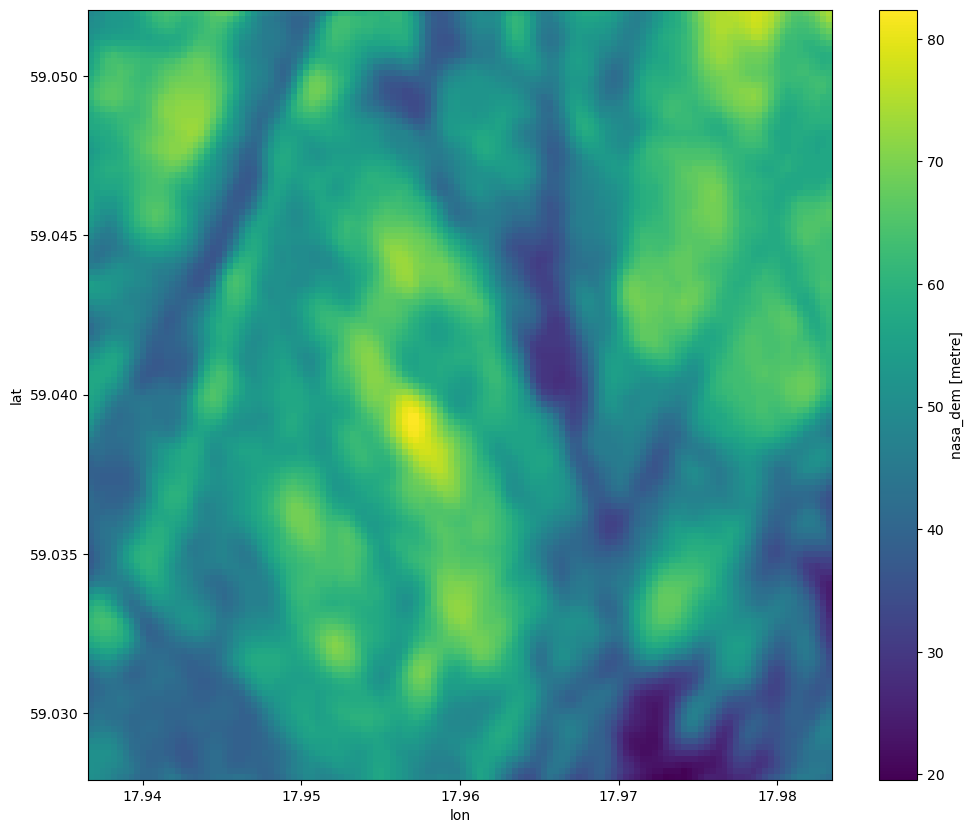

In [75]:
sweden.nasa_dem.plot.imshow(figsize = (12, 10))


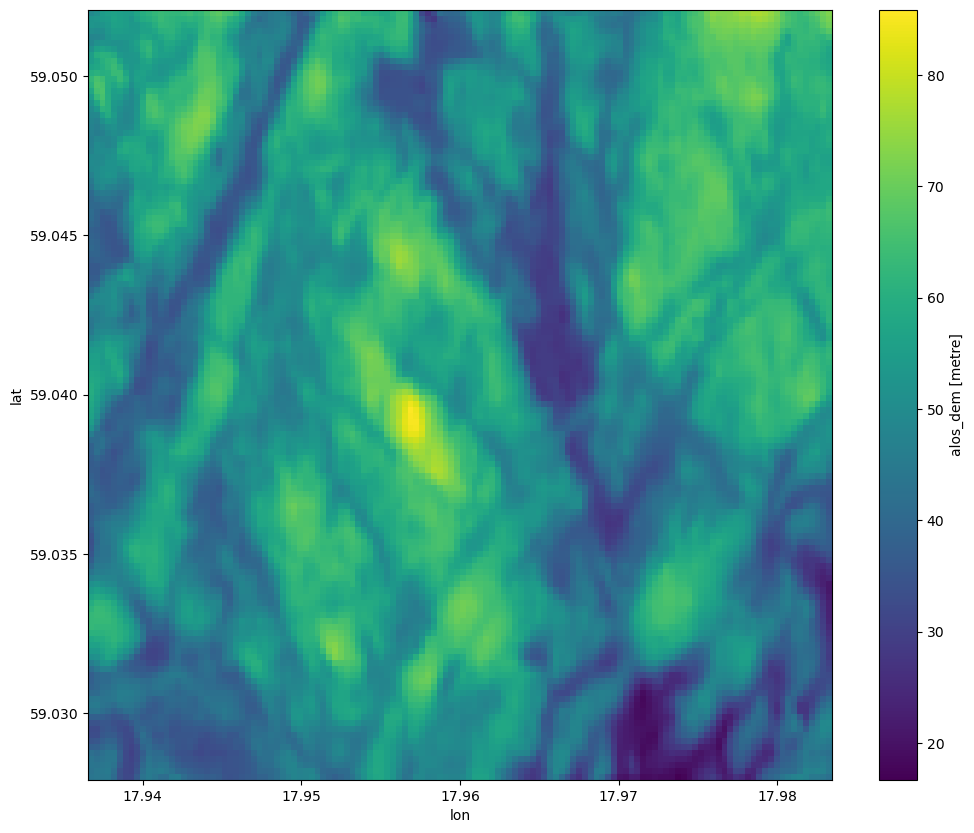

In [74]:
sweden.alos_dem.plot.imshow(figsize = (12, 10))
# input.alos_dem.plot.imshow(figsize = (12, 10))

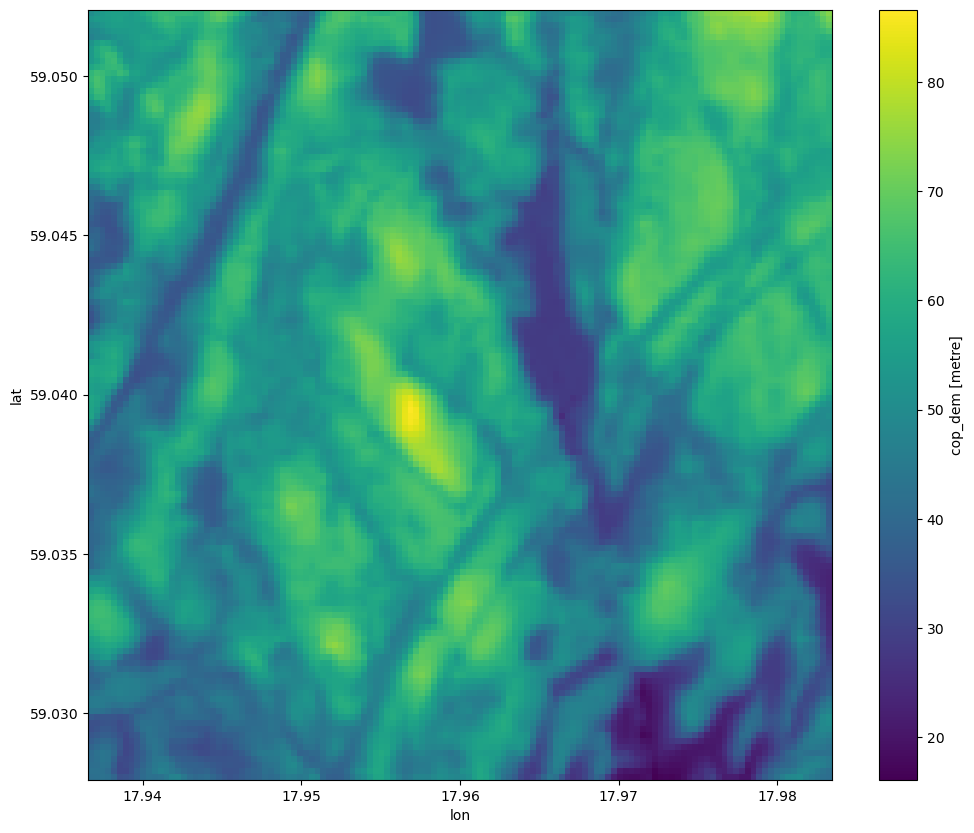

In [73]:
sweden.cop_dem.plot.imshow(figsize = (12, 10))
# input.cop_dem.plot.imshow(figsize = (12, 10))

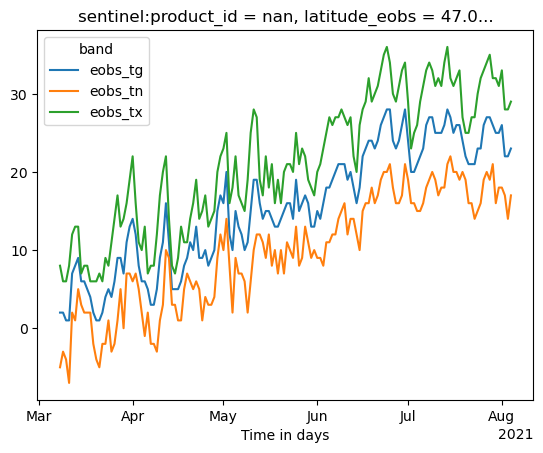

In [43]:
input[["eobs_tg","eobs_tn","eobs_tx"]].to_array("band").plot(hue = "band")

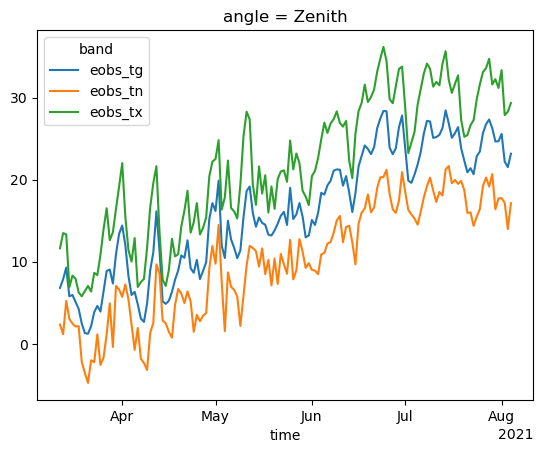

In [44]:
cube[["eobs_tg","eobs_tn","eobs_tx"]].to_array("band").plot(hue = "band")